### Hierarchical Agent Teams for Superior Quality
So far, we have explored how agents can generate ideas and evaluate them in parallel.

But complex tasks are often unexpected or unseen, requiring the agent to decide what and when to execute, introducing a delay between planning and action.



<p align="center">
  <img src="../../figures/hierarchical_agents.png" width="1200">
</p>

Specialization and Decomposition architecture pattern is the right way to solve this issue.

A complex task is given to a high-level Orchestrator (or Manager) agent. This agent doesn’t perform the task itself. instead, its job is to plan.
It decomposes the complex task into smaller, well-defined sub-tasks and delegates them to a team of specialized Worker agents.
These workers can often execute their tasks in parallel. Finally, the Orchestrator synthesizes the results from the workers into a single, cohesive output.


We will conduct a direct comparison between a Monolithic Agent and a Hierarchical Team on an investment report generation task to prove that the hierarchical approach produces a final report that is not only faster but also qualitatively superior in its detail, structure, and accuracy.

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from pydantic import BaseModel, Field
from typing import Optional, List

class FinancialData(BaseModel):
    """A Pydantic model for the structured output of the Financial Analyst agent."""
    price: float = Field(description="Current stock price.")
    market_cap: int = Field(description="Total market capitalization.")
    pe_ratio: float = Field(description="Price-to-Earnings ratio.")
    volume: int = Field(description="Average trading volume.")

class NewsAndMarketAnalysis(BaseModel):
    """A Pydantic model for the structured output of the News & Market Analyst agent."""
    summary: str = Field(description="A concise summary of the most important recent news and market trends.")
    competitors: List[str] = Field(description="A list of the company's main competitors.")

class FinalReport(BaseModel):
    """A Pydantic model for the final, synthesized investment report from the Chief Analyst."""
    company_name: str = Field(description="The name of the company.")
    financial_summary: str = Field(description="A paragraph summarizing the key financial data.")
    news_and_market_summary: str = Field(description="A paragraph summarizing the news, market trends, and competitive landscape.")
    recommendation: str = Field(description="A final investment recommendation (e.g., 'Strong Buy', 'Hold', 'Sell') with a brief justification.")

In [3]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class TeamGraphState(TypedDict):
    company_symbol: str
    company_name: str
    # 'financial_data' will hold the structured output from the Financial Analyst.
    financial_data: Optional[FinancialData]
    # 'news_analysis' will hold the structured output from the News & Market Analyst.
    news_analysis: Optional[NewsAndMarketAnalysis]
    # 'final_report' is the final product from the synthesizer.
    final_report: Optional[FinalReport]
    performance_log: Annotated[List[str], add_messages]

In [6]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

Now, let’s define the specialist Worker agents. Each is a self-contained, tool-using agent with a highly focused prompt. Let's create the node for our Financial Analyst.

In [7]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
import yfinance as yf

@tool
def get_financial_data(symbol: str) -> dict:
    """Fetches key financial data for a given stock symbol. Returns data such as price, market cap, P/E ratio, and recent volume."""
    print(f"--- [Tool Call] Fetching financial data for: {symbol} ---")
    ticker = yf.Ticker(symbol)
    info = ticker.info
    return {
        "price": info.get('currentPrice', 'N/A'),
        "market_cap": info.get('marketCap', 'N/A'),
        "pe_ratio": info.get('trailingPE', 'N/A'),
        "volume": info.get('averageVolume', 'N/A'),
    }

tavily_search = TavilySearchResults(max_results=5)

@tool
def get_news_and_market_analysis(company_name: str) -> list:
    """Performs a web search for recent news, market trends, and competitive analysis related to a company."""
    print(f"--- [Tool Call] Searching for news & analysis on: {company_name} ---")
    query = f"Latest news, market trends, and competitive landscape for {company_name}"
    return tavily_search.invoke(query)


/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_73239/2849885493.py:18: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=5)


In [17]:
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableLambda
import time

analyst_parser = JsonOutputParser(
    name="analyst_parser",
    pydantic_object=FinancialData
)

# Create a self-contained agent executor for the Financial Analyst.
# Its prompt is highly focused on its single task.
financial_analyst_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert financial analyst. Your sole job is to use the provided tool to get key financial metrics for a company and return them in a structured format.\n\n{format_instructions}"),
    ("human", "Get the financial data for the company with stock symbol: {symbol}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
]).partial(format_instructions=analyst_parser.get_format_instructions())

# This agent ONLY has access to the 'get_financial_data' tool.
financial_agent = create_tool_calling_agent(llm, [get_financial_data], financial_analyst_prompt)

# The final step in the chain forces the agent's output into our 'FinancialData' Pydantic model.
# financial_executor = AgentExecutor(agent=financial_agent, tools=[get_financial_data]) | llm | analyst_parser
financial_executor = (
    AgentExecutor(agent=financial_agent, tools=[get_financial_data])
    | RunnableLambda(lambda x: x["output"])
    | analyst_parser
)

def financial_analyst_node(state: TeamGraphState):
    """The specialist node for fetching and structuring financial data."""
    print("--- [Financial Analyst] Starting analysis... ---")
    start_time = time.time()
    result = financial_executor.invoke({"symbol": state['company_symbol']})
    execution_time = time.time() - start_time
    log = f"[Financial Analyst] Completed in {execution_time:.2f}s."
    print(log)
    return {"financial_data": result, "performance_log": [log]}

In [18]:
news_parser = JsonOutputParser(
    name="news_parser",
    pydantic_object=NewsAndMarketAnalysis
)

# News & Market Analyst Agent
news_analyst_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert market research analyst. Your sole job is to use the provided tool to get recent news and market analysis for a company, then summarize it and identify competitors in a structured format.\n\n{format_instructions}"),
    ("human", "Get the news and market analysis for: {company_name}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
]).partial(format_instructions=news_parser.get_format_instructions())

news_agent = create_tool_calling_agent(llm, [get_news_and_market_analysis], news_analyst_prompt)
# news_executor = AgentExecutor(agent=news_agent, tools=[get_news_and_market_analysis]) | llm | news_parser
news_executor = (
    AgentExecutor(agent=news_agent, tools=[get_news_and_market_analysis])
    | RunnableLambda(lambda x: x["output"])
    | news_parser
)

def news_analyst_node(state: TeamGraphState):
    """The specialist agent for news and market analysis."""
    print("--- [News & Market Analyst] Starting research... ---")
    start_time = time.time()
    result = news_executor.invoke({"company_name": state['company_name']})
    execution_time = time.time() - start_time
    log = f"[News & Market Analyst] Completed in {execution_time:.2f}s."
    print(log)
    return {"news_analysis": result, "performance_log": [log]}

### Defining the Orchestrator/Synthesizer Node

In [27]:
import json

synthesizer_parser = JsonOutputParser(
    name="synthesizer_parser",
    pydantic_object=FinalReport
)

report_synthesizer_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are the Chief Investment Analyst. Your job is to synthesize the structured financial data and market analysis provided by your specialist team into a final, comprehensive investment report, including a justified recommendation.\n\n{format_instructions}"),
    ("human", "Please create the final report for {company_name}.\n\nFinancial Data:\n{financial_data}\n\nNews and Market Analysis:\n{news_analysis}"),
]).partial(format_instructions=news_parser.get_format_instructions())

synthesizer_chain = report_synthesizer_prompt | llm | synthesizer_parser

def report_synthesizer_node(state: TeamGraphState):
    """The orchestrator node that synthesizes the final report."""
    print("--- [Chief Analyst] Synthesizing final report... ---")
    start_time = time.time()
    
    # The state contains the structured outputs from the workers
    report = synthesizer_chain.invoke({
        "company_name": state['company_name'],
        "financial_data": json.dumps(state['financial_data'], indent=2),
        "news_analysis": json.dumps(state['news_analysis'], indent=2)
    })
    
    execution_time = time.time() - start_time
    log = f"[Chief Analyst] Completed report in {execution_time:.2f}s."
    print(log)
    return {"final_report": report, "performance_log": [log]}

### Assembling the Graph
The graph structure is a classic "fan-out, fan-in". The entry point triggers both specialist workers in parallel. Once both have completed, their results are aggregated in the state, and the flow converges on the synthesizer node.

In [28]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(TeamGraphState)

# Add the nodes for the specialist agents and the synthesizer
workflow.add_node("financial_analyst", financial_analyst_node)
workflow.add_node("news_analyst", news_analyst_node)
workflow.add_node("report_synthesizer", report_synthesizer_node)

# The entry point fans out to the two specialist workers, starting them in parallel
workflow.add_edge(START, "financial_analyst")
workflow.add_edge(START, "news_analyst")

# When both workers are done, the flow converges to the synthesizer
workflow.add_edge("financial_analyst", "report_synthesizer")
workflow.add_edge("news_analyst", "report_synthesizer")

# The synthesizer is the final step
workflow.add_edge("report_synthesizer", END)

app = workflow.compile()

print("Graph constructed and compiled successfully.")
print("The hierarchical agent team is ready.")

Graph constructed and compiled successfully.
The hierarchical agent team is ready.


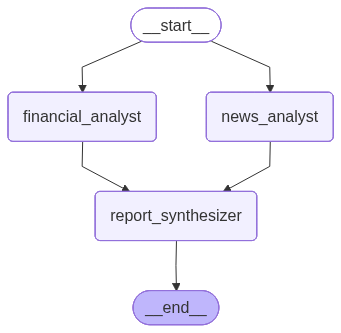

In [29]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [30]:
inputs = {
    "company_symbol": "TSLA",
    "company_name": "Tesla",
    "performance_log": []
}

start_time = time.time()
team_result = None
for output in app.stream(inputs, stream_mode="values"):
    team_result = output
end_time = time.time()
team_time = end_time - start_time

--- [Financial Analyst] Starting analysis... ------ [News & Market Analyst] Starting research... ---

--- [Tool Call] Searching for news & analysis on: Tesla ---
--- [Tool Call] Fetching financial data for: TSLA ---
[Financial Analyst] Completed in 3.29s.
[News & Market Analyst] Completed in 7.87s.
--- [Chief Analyst] Synthesizing final report... ---
[Chief Analyst] Completed report in 2.86s.


In [31]:
print("\n" + "-"*60)
print("            HIERARCHICAL TEAM REPORT")
print("-"*60 + "\n")
print(json.dumps(team_result['final_report'], indent=4, default=lambda o: o.dict()))
print("\n" + "="*60)
print("                      ACCURACY & QUALITY ANALYSIS")
print("="*60 + "\n")

print("="*60)
print("                      PERFORMANCE ANALYSIS")
print("="*60 + "\n")
print(f"Hierarchical Team Total Time: {team_time:.2f} seconds\n") 


------------------------------------------------------------
            HIERARCHICAL TEAM REPORT
------------------------------------------------------------

{
    "summary": "Tesla is facing increased competition from dedicated EV manufacturers like BYD, which has outsold Tesla in Europe for the first time. Traditional automakers are also making significant inroads with their EV offerings, leveraging global reach and resources to challenge Tesla's market position. Tesla has seen a decline in European car registrations, attributed to growing competition and market saturation. However, Tesla is experiencing strong demand in China, particularly for the Model Y, with record sales and a rebound in November. The company is also making technical advancements, such as updates to its exterior cameras and continued development of Full Self-Driving (FSD) technology. Market sentiment remains mixed, with some analysts questioning Tesla's valuation, while others remain optimistic about its innov